In [2]:
import pandas as pd
import numpy as np
import string
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization, Dropout, GlobalMaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D
from tensorflow.keras.optimizers import Adam

from scipy.sparse import vstack

import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'keras'

# 1. Load and prepare data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
s140_names = ["Sentiment", "Id", "Date", "Query", "User", "Text"]

df_s140_train = pd.read_csv("/content/drive/MyDrive/s140_train.csv", names=s140_names, encoding='latin-1')
df_s140_test = pd.read_csv("/content/drive/MyDrive/s140_test.csv", names=s140_names, encoding='latin-1')

df_rtmr_train = pd.read_csv("/content/drive/MyDrive/rtmr_train.tsv", sep="\t")
df_rtmr_train = df_rtmr_train.rename(columns={"Phrase": "Text"})
df_rtmr_test = pd.read_csv("/content/drive/MyDrive/rtmr_test.tsv", sep="\t")
df_rtmr_test = df_rtmr_test.rename(columns={"Phrase": "Text"})

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/s140_train.csv'

In [4]:
df_s140_train.head()

NameError: name 'df_s140_train' is not defined

In [5]:
df_rtmr_train.head()

NameError: name 'df_rtmr_train' is not defined

# 2. Transform input text

In [6]:
# general preprocessing function

def preprocess(text):
    tokens = [token for token in word_tokenize(text)]

    stops = stopwords.words("english") + list(string.punctuation)
    
    lemmatizer = WordNetLemmatizer()
    
    tokens_no_hashtag = [re.sub(r'#', '', token) for token in tokens]
    tokens_no_stopwords = [token.lower() for token in tokens_no_hashtag if token.lower() not in stops]
    tokens_no_url = [re.sub(r'http\S+', '', token) for token in tokens_no_stopwords]
    tokens_no_url = [re.sub(r'www\S+', '', token) for token in tokens_no_url]
    tokens_no_extra_space = [re.sub(r'\s\s+', '', token) for token in tokens_no_url]
    tokens_alnum = [token for token in tokens_no_extra_space if token.isalnum()]
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_alnum]
    tokens_final = [token for token in tokens_lemma if len(token) > 0]
    
    return tokens_final

In [7]:
df_s140_train['Text'] = df_s140_train['Text'].apply(preprocess)
df_s140_test['Text'] = df_s140_test['Text'].apply(preprocess)

df_rtmr_train['Text'] = df_rtmr_train['Text'].apply(preprocess)
df_rtmr_test['Text'] = df_rtmr_test['Text'].apply(preprocess)

NameError: name 'df_s140_train' is not defined

In [8]:
df_s140_train.head()

NameError: name 'df_s140_train' is not defined

In [9]:
df_rtmr_train.head()

NameError: name 'df_rtmr_train' is not defined

In [10]:
df_s140_train['Text'] = df_s140_train['Text'].apply(lambda x:' '.join(x))
df_s140_test['Text'] = df_s140_test['Text'].apply(lambda x:' '.join(x))

df_rtmr_train['Text'] = df_rtmr_train['Text'].apply(lambda x:' '.join(x))
df_rtmr_test['Text'] = df_rtmr_test['Text'].apply(lambda x:' '.join(x))

NameError: name 'df_s140_train' is not defined

# 3. Metrics

In [11]:
def get_metrics(y_pred, y_actual, clf):
    acc = accuracy_score(y_actual, y_pred)
    print("accuracy: {}".format(acc))
    
    print(classification_report(y_actual, y_pred))
    
    cm = confusion_matrix(y_actual, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()

# 4. Naive Bayes

In [12]:
# Vectorization of text for Naive Bayes

vectorizer = CountVectorizer()
vectorizer.fit(df_s140_train['Text'].append(df_s140_test['Text']).append(df_rtmr_train['Text']).append(df_rtmr_test['Text']))

s140_train_X = vectorizer.transform(df_s140_train['Text'])
s140_test_X = vectorizer.transform(df_s140_test['Text'])

rtmr_train_X = vectorizer.transform(df_rtmr_train['Text'])
rtmr_test_X = vectorizer.transform(df_rtmr_test['Text'])

NameError: name 'df_s140_train' is not defined

## 4.1. Trained on RTMR and tested on both

In [13]:
# trained on RTMR
nb1 = MultinomialNB() # default smoothing parameter alpha=1
nb1.fit(rtmr_train_X, df_rtmr_train["Sentiment"])

NameError: name 'rtmr_train_X' is not defined

In [14]:
# tested on S140
s140_test_pred = nb1.predict(s140_test_X)
s140_test_actual = df_s140_test["Sentiment"].to_numpy()

get_metrics(s140_test_pred, s140_test_actual, nb1)

NameError: name 's140_test_X' is not defined

In [15]:
# tested on RTMR
rtmr_test_pred = nb1.predict(rtmr_test_X)
rtmr_test_actual = df_rtmr_test["Sentiment"].to_numpy()

get_metrics(rtmr_test_pred, rtmr_test_actual, nb1)

NameError: name 'rtmr_test_X' is not defined

## 4.2. Trained on S140 and tested on both

In [25]:
# trained on S140
nb2 = MultinomialNB() # default smoothing parameter alpha=1
nb2.fit(s140_train_X, df_s140_train["Sentiment"])

MultinomialNB()

accuracy: 0.5823293172690763
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       177
           2       0.00      0.00      0.00       139
           4       0.52      0.80      0.63       182

    accuracy                           0.58       498
   macro avg       0.40      0.54      0.45       498
weighted avg       0.43      0.58      0.49       498



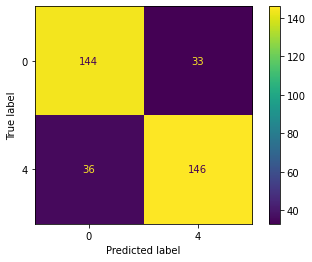

In [ ]:
# tested on S140
s140_test_pred = nb2.predict(s140_test_X)
s140_test_actual = df_s140_test["Sentiment"].to_numpy()

get_metrics(s140_test_pred, s140_test_actual, nb2)

accuracy: 0.0726643598615917
              precision    recall  f1-score   support

           0       0.07      0.62      0.12       306
           1       0.00      0.00      0.00      1400
           2       0.00      0.00      0.00      4027
           3       0.00      0.00      0.00      1638
           4       0.08      0.88      0.14       432

    accuracy                           0.07      7803
   macro avg       0.03      0.30      0.05      7803
weighted avg       0.01      0.07      0.01      7803



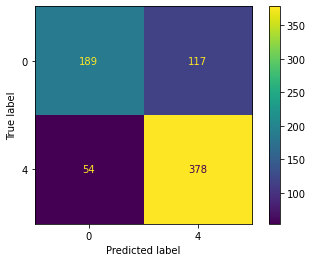

In [ ]:
# tested on RTMR
rtmr_test_pred = nb2.predict(rtmr_test_X)
rtmr_test_actual = df_rtmr_test["Sentiment"].to_numpy()

get_metrics(rtmr_test_pred, rtmr_test_actual, nb2)

## 4.3. Trained on both and tested on both

In [26]:
# trained on both
nb3 = MultinomialNB() # default smoothing parameter alpha=1
all_train_X = vstack([s140_train_X, rtmr_train_X])
all_train_y = df_s140_train["Sentiment"].append(df_rtmr_train["Sentiment"])
nb3.fit(all_train_X, all_train_y)

MultinomialNB()

accuracy: 0.5783132530120482
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       177
           2       0.00      0.00      0.00       139
           4       0.52      0.80      0.63       182

    accuracy                           0.58       498
   macro avg       0.39      0.53      0.45       498
weighted avg       0.43      0.58      0.49       498



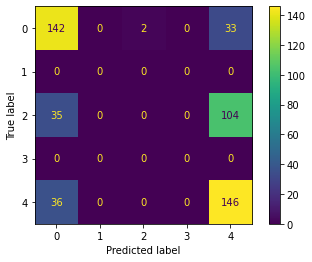

In [ ]:
# tested on S140
s140_test_pred = nb3.predict(s140_test_X)
s140_test_actual = df_s140_test["Sentiment"].to_numpy()

get_metrics(s140_test_pred, s140_test_actual, nb3)

accuracy: 0.22837370242214533
              precision    recall  f1-score   support

           0       0.08      0.50      0.13       306
           1       0.51      0.07      0.12      1400
           2       0.54      0.27      0.36      4027
           3       0.52      0.13      0.21      1638
           4       0.07      0.55      0.13       432

    accuracy                           0.23      7803
   macro avg       0.34      0.30      0.19      7803
weighted avg       0.48      0.23      0.26      7803



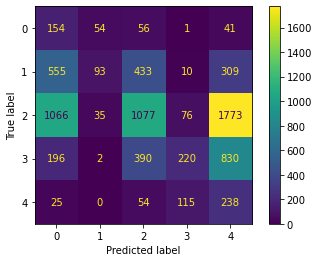

In [ ]:
# tested on RTMR
rtmr_test_pred = nb3.predict(rtmr_test_X)
rtmr_test_actual = df_rtmr_test["Sentiment"].to_numpy()

get_metrics(rtmr_test_pred, rtmr_test_actual, nb3)

# 5. CNN

## 5.1 Transform text to sequence

In [6]:
# Vectorization of text for CNN

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')

s140_train_n = df_s140_train.shape[0]
s140_test_n = df_s140_test.shape[0]
rtmr_train_n = df_rtmr_train.shape[0]
rtmr_test_n = df_rtmr_test.shape[0]

all_text = df_s140_train['Text'].append(df_s140_test['Text']).append(df_rtmr_train['Text']).append(df_rtmr_test['Text'])

tokenizer.fit_on_texts(all_text.values)
X = tokenizer.texts_to_sequences(all_text.values)
X = pad_sequences(X)

s140_train_X = X[:s140_train_n, :]
s140_test_X = X[s140_train_n:(s140_train_n+s140_test_n), :]
rtmr_train_X = X[(s140_train_n+s140_test_n):(s140_train_n+s140_test_n+rtmr_train_n), :]
rtmr_test_X = X[(s140_train_n+s140_test_n+rtmr_train_n):, :]

In [7]:
# Encode labels(sentiment values) using one hot encoding

all_y = df_s140_train['Sentiment'].append(df_s140_test['Sentiment']).append(df_rtmr_train['Sentiment']).append(df_rtmr_test['Sentiment'])

all_y_dummies = pd.get_dummies(all_y).values

s140_train_y = all_y_dummies[:s140_train_n, :]
s140_test_y = all_y_dummies[s140_train_n:(s140_train_n+s140_test_n), :]
rtmr_train_y = all_y_dummies[(s140_train_n+s140_test_n):(s140_train_n+s140_test_n+rtmr_train_n), :]
rtmr_test_y = all_y_dummies[(s140_train_n+s140_test_n+rtmr_train_n):, :]

## 5.2 Build CNN model

In [8]:
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 100, input_length=rtmr_train_X.shape[1]))
model_CNN.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dropout(0.5))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(2048, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(5, activation='softmax'))

loss = 'categorical_crossentropy'
metrics = ['accuracy']
learning_rate = 0.001
optimizer = Adam(learning_rate)
model_CNN.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model_CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 100)           200000    
                                                                 
 conv1d (Conv1D)             (None, 46, 1024)          308224    
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

## 5.3 Trained on RTMR

In [9]:
batch_size=32

history = model_CNN.fit(
    rtmr_train_X[:100000,:], 
    rtmr_train_y[:100000,:],
    batch_size=batch_size,
    epochs=20,
    verbose=2,
    validation_split=0.2
    )

Epoch 1/20
2500/2500 - 41s - loss: 1.5250 - accuracy: 0.4573 - val_loss: 1.1840 - val_accuracy: 0.5450 - 41s/epoch - 17ms/step
Epoch 2/20
2500/2500 - 30s - loss: 1.3216 - accuracy: 0.5061 - val_loss: 1.1688 - val_accuracy: 0.5496 - 30s/epoch - 12ms/step
Epoch 3/20
2500/2500 - 30s - loss: 1.2638 - accuracy: 0.5194 - val_loss: 1.1572 - val_accuracy: 0.5484 - 30s/epoch - 12ms/step
Epoch 4/20
2500/2500 - 29s - loss: 1.2195 - accuracy: 0.5331 - val_loss: 1.1385 - val_accuracy: 0.5602 - 29s/epoch - 12ms/step
Epoch 5/20
2500/2500 - 30s - loss: 1.1805 - accuracy: 0.5433 - val_loss: 1.1544 - val_accuracy: 0.5543 - 30s/epoch - 12ms/step
Epoch 6/20
2500/2500 - 30s - loss: 1.1490 - accuracy: 0.5544 - val_loss: 1.1284 - val_accuracy: 0.5617 - 30s/epoch - 12ms/step
Epoch 7/20
2500/2500 - 30s - loss: 1.1230 - accuracy: 0.5630 - val_loss: 1.1291 - val_accuracy: 0.5620 - 30s/epoch - 12ms/step
Epoch 8/20
2500/2500 - 30s - loss: 1.1033 - accuracy: 0.5701 - val_loss: 1.1194 - val_accuracy: 0.5665 - 30s/ep

## 5.4 Tested on RTMR

244/244 - 1s - loss: 1.1195 - accuracy: 0.5786 - 1s/epoch - 6ms/step

 accuracy: 0.5786235928535461 

              precision    recall  f1-score   support

           0       0.35      0.24      0.29       306
           1       0.49      0.27      0.35      1400
           2       0.61      0.87      0.72      4027
           3       0.51      0.28      0.36      1638
           4       0.44      0.19      0.27       432

    accuracy                           0.58      7803
   macro avg       0.48      0.37      0.40      7803
weighted avg       0.55      0.58      0.54      7803



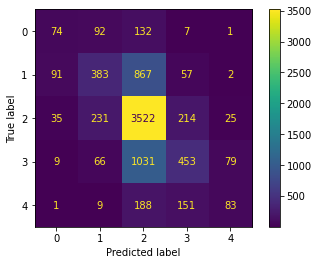

In [17]:
loss, acc = model_CNN.evaluate(rtmr_test_X, rtmr_test_y, verbose=2, batch_size=batch_size)

rtmr_test_y_predict = model_CNN.predict(rtmr_test_X) 
rtmr_test_y_predict = np.argmax(rtmr_test_y_predict, axis=1)
rtmr_test_y_true = [row.index(1) for row in rtmr_test_y.tolist()]

print("\n accuracy: {} \n".format(acc))
    
print(classification_report(rtmr_test_y_true, rtmr_test_y_predict))

cm = confusion_matrix(rtmr_test_y_true, rtmr_test_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 5.5 Tested on S140

16/16 - 0s - loss: 3.0997 - accuracy: 0.2570 - 114ms/epoch - 7ms/step

 accuracy: 0.25702810287475586 

              precision    recall  f1-score   support

           0       0.57      0.16      0.25       177
           1       0.00      0.00      0.00         0
           2       0.41      0.53      0.46       139
           3       0.00      0.00      0.00         0
           4       0.68      0.15      0.24       182

    accuracy                           0.26       498
   macro avg       0.33      0.17      0.19       498
weighted avg       0.56      0.26      0.31       498



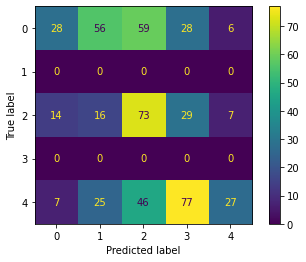

In [18]:
loss, acc = model_CNN.evaluate(s140_test_X, s140_test_y, verbose=2, batch_size=batch_size)

s140_test_y_predict = model_CNN.predict(s140_test_X) 
s140_test_y_predict = np.argmax(s140_test_y_predict, axis=1)
s140_test_y_true = [row.index(1) for row in s140_test_y.tolist()]

print("\n accuracy: {} \n".format(acc))
    
print(classification_report(s140_test_y_true, s140_test_y_predict))

cm = confusion_matrix(s140_test_y_true, s140_test_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 6. LSTM

## 6.1 Transform text to sequence

In [ ]:
# Vectorization of text for LSTM

max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')

s140_train_n = df_s140_train.shape[0]
s140_test_n = df_s140_test.shape[0]
rtmr_train_n = df_rtmr_train.shape[0]
rtmr_test_n = df_rtmr_test.shape[0]

all_text = df_s140_train['Text'].append(df_s140_test['Text']).append(df_rtmr_train['Text']).append(df_rtmr_test['Text'])

tokenizer.fit_on_texts(all_text.values)
X = tokenizer.texts_to_sequences(all_text.values)
X = pad_sequences(X)

s140_train_X = X[:s140_train_n, :]
s140_test_X = X[s140_train_n:(s140_train_n+s140_test_n), :]
rtmr_train_X = X[(s140_train_n+s140_test_n):(s140_train_n+s140_test_n+rtmr_train_n), :]
rtmr_test_X = X[(s140_train_n+s140_test_n+rtmr_train_n):, :]

In [ ]:
# Encode labels(sentiment values) using one hot encoding

all_y = df_s140_train['Sentiment'].append(df_s140_test['Sentiment']).append(df_rtmr_train['Sentiment']).append(df_rtmr_test['Sentiment'])

all_y_dummies = pd.get_dummies(all_y).values

s140_train_y = all_y_dummies[:s140_train_n, :]
s140_test_y = all_y_dummies[s140_train_n:(s140_train_n+s140_test_n), :]
rtmr_train_y = all_y_dummies[(s140_train_n+s140_test_n):(s140_train_n+s140_test_n+rtmr_train_n), :]
rtmr_test_y = all_y_dummies[(s140_train_n+s140_test_n+rtmr_train_n):, :]

## 6.2 Build LSTM model

In [12]:
embed_dim = 128
lstm_out = 196

model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, embed_dim, input_length = rtmr_train_X.shape[1]))
model_LSTM.add(SpatialDropout1D(0.4))
model_LSTM.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(5, activation='softmax'))
model_LSTM.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_LSTM.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 48, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 48, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense_2 (Dense)             (None, 5)                 985       
                                                                 
Total params: 511,785
Trainable params: 511,785
Non-trainable params: 0
_________________________________________________________________
None


## 6.3 Trained on RTMR

In [14]:
batch_size = 32
model_LSTM.fit(rtmr_train_X[:10000,:], rtmr_train_y[:10000,:], epochs=10, batch_size=batch_size, verbose=2)

Epoch 1/10
313/313 - 133s - loss: 1.1109 - accuracy: 0.5766 - 133s/epoch - 424ms/step
Epoch 2/10
313/313 - 109s - loss: 1.0601 - accuracy: 0.5919 - 109s/epoch - 348ms/step
Epoch 3/10
313/313 - 108s - loss: 1.0260 - accuracy: 0.6087 - 108s/epoch - 347ms/step
Epoch 4/10
313/313 - 108s - loss: 0.9989 - accuracy: 0.6223 - 108s/epoch - 346ms/step
Epoch 5/10
313/313 - 148s - loss: 0.9735 - accuracy: 0.6326 - 148s/epoch - 472ms/step
Epoch 6/10
313/313 - 117s - loss: 0.9524 - accuracy: 0.6400 - 117s/epoch - 374ms/step
Epoch 7/10
313/313 - 109s - loss: 0.9343 - accuracy: 0.6449 - 109s/epoch - 349ms/step
Epoch 8/10
313/313 - 108s - loss: 0.9144 - accuracy: 0.6545 - 108s/epoch - 344ms/step
Epoch 9/10
313/313 - 108s - loss: 0.9022 - accuracy: 0.6628 - 108s/epoch - 344ms/step
Epoch 10/10
313/313 - 111s - loss: 0.8856 - accuracy: 0.6662 - 111s/epoch - 356ms/step


## 6.4 Tested on RTMR

244/244 - 11s - loss: 1.3729 - accuracy: 0.5258 - 11s/epoch - 44ms/step

 accuracy: 0.5258234143257141 

              precision    recall  f1-score   support

           0       0.29      0.16      0.20       306
           1       0.38      0.22      0.28      1400
           2       0.60      0.79      0.68      4027
           3       0.38      0.30      0.34      1638
           4       0.31      0.15      0.20       432

    accuracy                           0.53      7803
   macro avg       0.39      0.32      0.34      7803
weighted avg       0.49      0.53      0.49      7803



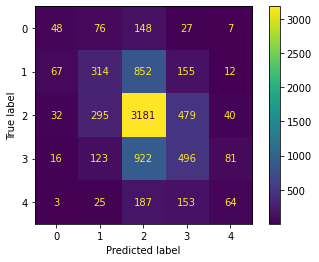

In [19]:
loss, acc = model_LSTM.evaluate(rtmr_test_X, rtmr_test_y, verbose=2, batch_size=batch_size)

rtmr_test_y_predict = model_LSTM.predict(rtmr_test_X) 
rtmr_test_y_predict = np.argmax(rtmr_test_y_predict, axis=1)
rtmr_test_y_true = [row.index(1) for row in rtmr_test_y.tolist()]

print("\n accuracy: {} \n".format(acc))
    
print(classification_report(rtmr_test_y_true, rtmr_test_y_predict))

cm = confusion_matrix(rtmr_test_y_true, rtmr_test_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 6.5 Tested on S140

In [2]:
loss, acc = model_LSTM.evaluate(s140_test_X, s140_test_y, verbose=2, batch_size=batch_size)

s140_test_y_predict = model_LSTM.predict(s140_test_X) 
s140_test_y_predict = np.argmax(s140_test_y_predict, axis=1)
s140_test_y_true = [row.index(1) for row in s140_test_y.tolist()]

print("\n accuracy: {} \n".format(acc))
    
print(classification_report(s140_test_y_true, s140_test_y_predict))

cm = confusion_matrix(s140_test_y_true, s140_test_y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

NameError: name 'model_LSTM' is not defined

# 7. Load the pre-trained model and make prediction

In [1]:
def predict(text, model):
    if model == "nb1":
        return nb1.predict(text)
    elif model == "nb2":
        return nb2.predict(text)
    elif model == "nb3":
        return nb3.predict(text)
    elif model == "cnn":
        return model_CNN.predict(text)
    elif model == "lstm":
        return model_LSTM.predict(text)
    else:
        print("Invalid model!")